## Sagnac Frequency - Backscatter Correction - Monobeam Power

## Imports

In [5]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [6]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [7]:
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence
from functions.cross_correlation_function_windows import __cross_correlation_function_windows
from functions.cross_correlation_windows import __cross_correlation_windows
from functions.load_backscatter_data import __load_backscatter_data

In [8]:
def __cc_lag_matrix(dat1, dat2, dt, twin_sec, T_lag_sec, dT_lag_sec, plot=False):

    L, dL = int(T_lag_sec/dt), int(dT_lag_sec/dt)

    Tlags = np.arange(-T_lag_sec, T_lag_sec+dT_lag_sec, dT_lag_sec)
    Nlags = np.arange(-L, L+dL, dL)

    for _k, lag in enumerate(Nlags):

        tt, cc = __cross_correlation_windows(dat1, dat2, dt, twin_sec, overlap=0.5, lag=lag, demean=True)

        if _k == 0:
            ccc = np.zeros((len(Nlags), len(cc)))

        ccc[_k] = cc

    if plot:
        plt.figure(figsize=(15, 5))

        cmap = plt.get_cmap("seismic")

        plt.pcolormesh(tt/86400, Tlags, ccc, vmin=-1, vmax=1, cmap=cmap)
        plt.ylabel("Lag Time (sec)")
        plt.xlabel("Time (days)")

        plt.show();

    return tt, Tlags, ccc

## Configurations

In [9]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

case = 10
# config['tbeg'] = UTCDateTime("2023-12-05 00:00")
# config['tend'] = UTCDateTime("2023-12-16 00:00")

config['tbeg'] = UTCDateTime("2023-12-08 00:00")
config['tend'] = UTCDateTime("2023-12-15 00:00")
flim1, flim2 = 302.425, 302.485

## note air ventilation on from 27-12-2023 !!!
# case = 11
# config['tbeg'] = UTCDateTime("2023-12-24 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")

# case = 12
# config['tbeg'] = UTCDateTime("2024-01-06 00:00")
# config['tend'] = UTCDateTime("2024-01-26 00:00")
# flim1, flim2 = 302.375, 302.475


## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [10]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Cut corrupt data periods

In [11]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    # bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    # bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)
    bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
bs['w_s'] = np.nan_to_num(bs['w_s'], nan=np.nanmedian(bs['w_s']))
bs['f1_ac'] = np.nan_to_num(bs['f1_ac'], nan=np.nanmedian(bs['f1_ac']))
bs['f2_ac'] = np.nan_to_num(bs['f2_ac'], nan=np.nanmedian(bs['f2_ac']))

(302.425, 302.485)

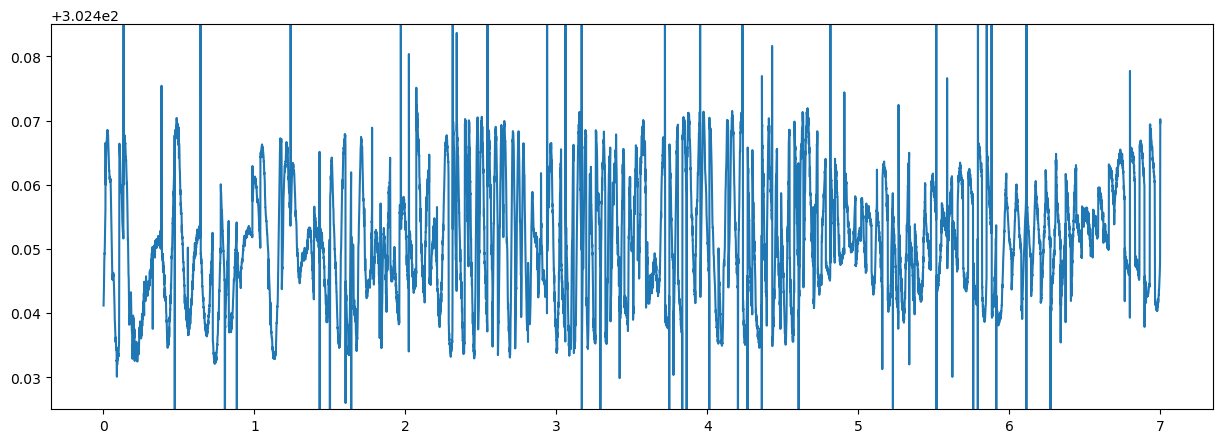

In [12]:
plt.figure(figsize=(15,5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

In [13]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [14]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [15]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "w_s", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "f1_ac", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "f2_ac", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)

In [16]:
tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.4
cond4 = bs.fj_fs_nan > 302.6

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['w_s_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.w_s_nan)
bs['w_s_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.w_s_nan)

bs['f1_ac'] = np.where(cond1 & cond2 & cond3, np.nan, bs.f1_ac_nan)
bs['f2_ac'] = np.where(cond1 & cond2 & cond4, np.nan, bs.f2_ac_nan)


In [17]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['w_s_inter'] = __interpolate_nan(np.array(bs.w_s_nan))
bs['f1_ac_inter'] = __interpolate_nan(np.array(bs.f1_ac_nan))
bs['f2_ac_inter'] = __interpolate_nan(np.array(bs.f2_ac_nan))


In [18]:
from functions.smoothing import __smooth

n_minutes = 180

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['w_s_smooth']   = __smooth(bs.w_s_inter, n_minutes)
bs['f1_ac_smooth']   = __smooth(bs.f1_ac_inter, n_minutes)
bs['f2_ac_smooth']   = __smooth(bs.f2_ac_inter, n_minutes)


/tmp/ipykernel_203978/964878966.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


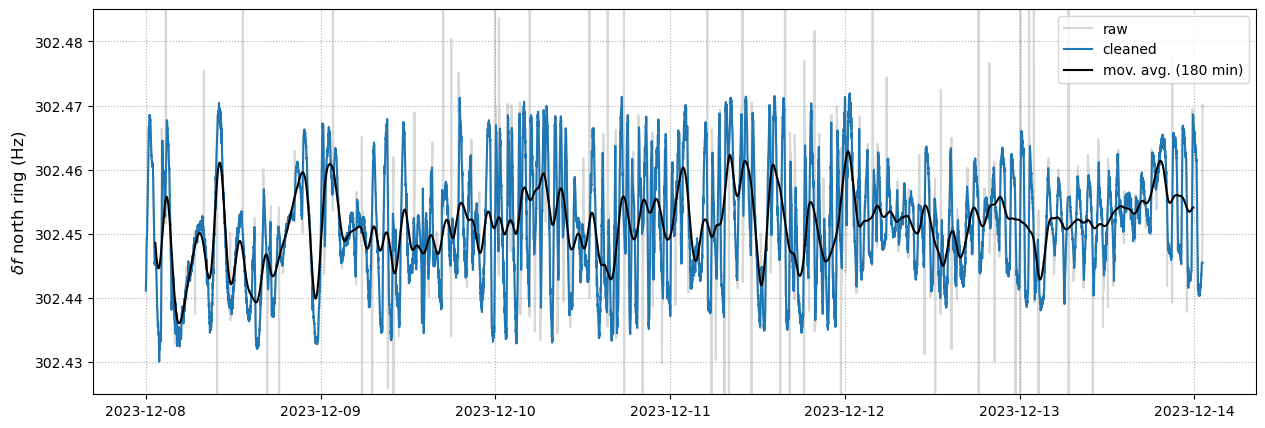

In [124]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="tab:blue", label="cleaned")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    # ax.set_xlim(left=0)


    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


0.008066777576619926


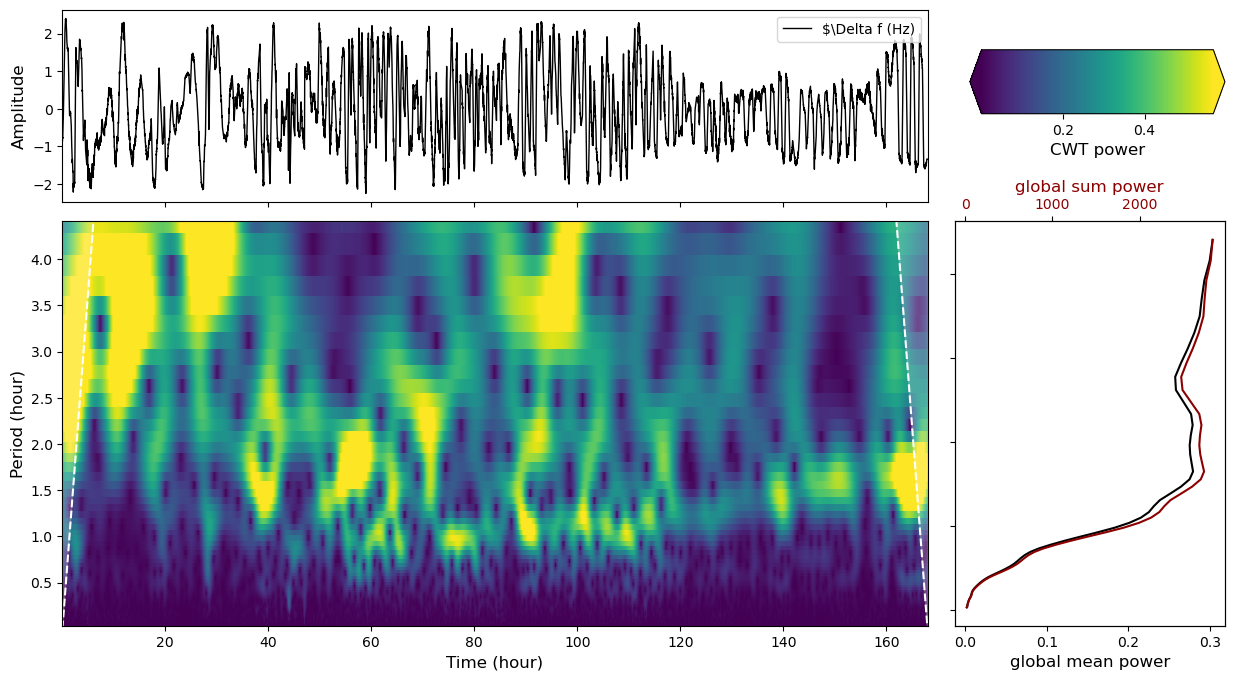

In [20]:
ttt = bs.time_sec
arr = bs.w_s_inter
dt  = 60 # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="$\Delta f (Hz)",
                    log=False, period=True, fmax=None, plot=True)

out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_1.png", format="png", dpi=200, bbox_inches='tight')


In [21]:
bs.keys()

Index(['index', 'time1', 'time2', 'fj_fs', 'fj_ac', 'fj_dc', 'fj_ph', 'f1_fs',
       'f1_ac', 'f1_dc', 'f1_ph', 'f2_fs', 'f2_ac', 'f2_dc', 'f2_ph', 'w_s',
       'time_sec', 'fj_fs_nan', 'w_s_nan', 'f1_ac_nan', 'f2_ac_nan',
       'fj_fs_inter', 'w_s_inter', 'f1_ac_inter', 'f2_ac_inter',
       'fj_fs_smooth', 'w_s_smooth', 'f1_ac_smooth', 'f2_ac_smooth'],
      dtype='object')

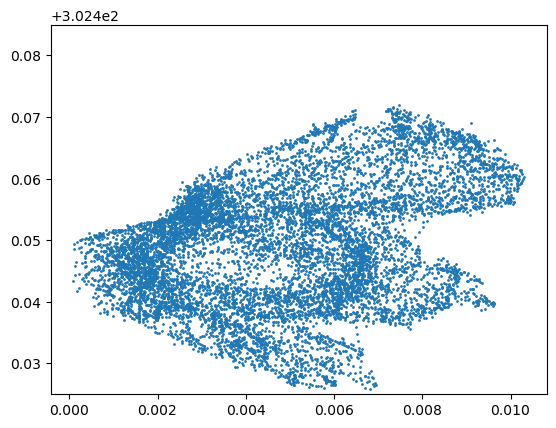

In [22]:
time_avg = 1

dat0 = __smooth(bs.w_s_inter, time_avg)
dat1 = __smooth(bs.f1_ac_inter, time_avg)
dat2 = __smooth(bs.f2_ac_inter, time_avg)


plt.scatter(dat2, dat0, s=1)
plt.ylim(flim1, flim2)

# plt.scatter(dat2, dat0, s=1)
# plt.ylim(flim1, flim2)

from andbro__calculate_linear_regression import __calculate_linear_regression

out = __calculate_linear_regression(dat2, dat0, odr_mode=False)

plt.plot(dat2, out['slope'] * dat2 + out['intercept'])

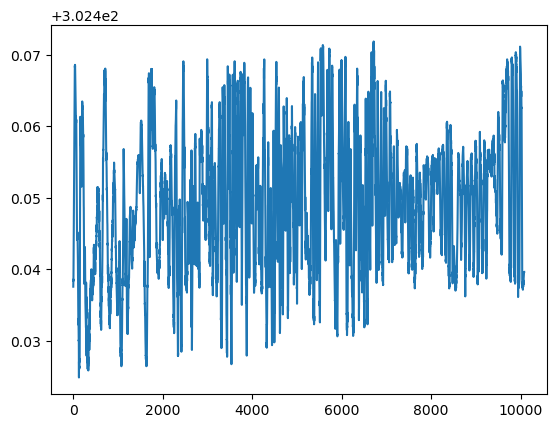

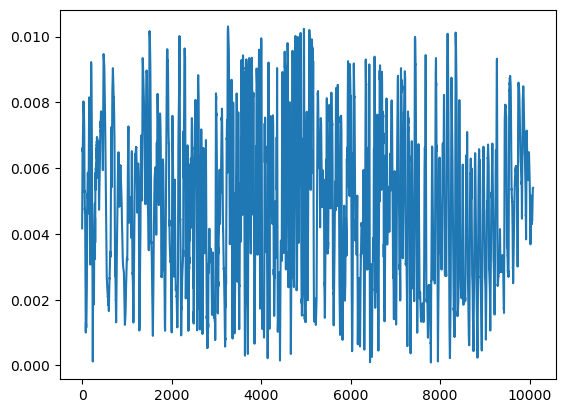

In [23]:
plt.figure()
plt.plot(dat0)

plt.figure()
plt.plot(dat2)

/tmp/ipykernel_203978/2221763919.py:49: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0, 1e-3)
/tmp/ipykernel_203978/2221763919.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tcklbls)


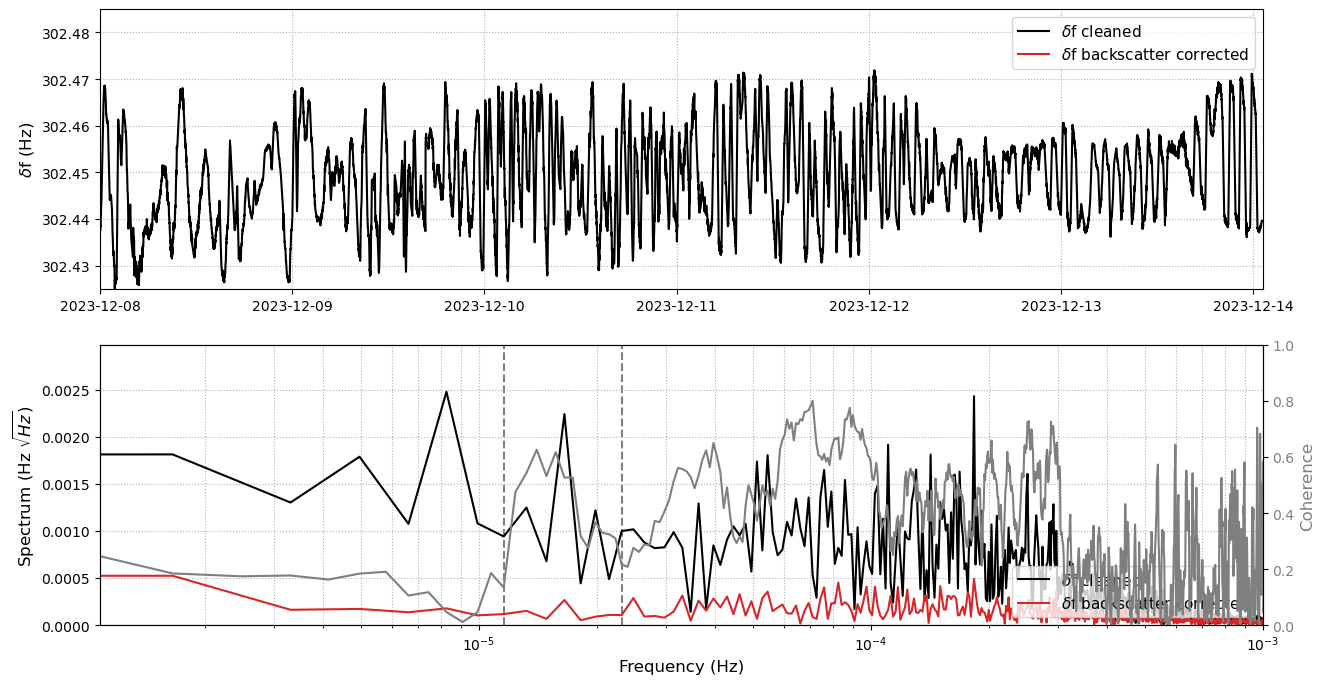

In [24]:
def __makeplot(key1, key2):

    dat1 = np.array((bs[key1] - bs[key1].mean()).replace(np.nan, 0))
    dat2 = np.array((bs[key2] - bs[key2].mean()).replace(np.nan, 0))


    out = __multitaper_coherence(dat1, dat2, 60, n_taper=10, time_bandwidth=3.5, method=0)


    f1, psd1, pha1 = __get_fft(dat1, 60)
    f2, psd2, pha2 = __get_fft(dat2, 60)


    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))


    ax[0].plot(bs.time_sec*time_scaling, bs[key1], color="black", label=f"$\delta$f cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs[key2], color="tab:red", label=f"$\delta$f backscatter corrected")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f cleaned")
    ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f backscatter corrected")

    # ax[1].semilogx(out['ff1'], out['psd1'], color="black", label=f"$\delta$f w/ backscatter")
    # ax[1].semilogx(out['ff2'], out['psd2'], color="tab:red", label=f"$\delta$f w/o backscatter")

    ax11 = ax[1].twinx()
    ax11.semilogx(out['fcoh'], out['coh'], color="tab:grey", label=f"coherence")
    ax11.set_ylim(0, 1.)
    ax11.set_ylabel(f"Coherence", fontsize=font, color="tab:grey")
    [t.set_color('tab:grey') for t in ax11.yaxis.get_ticklabels()]

    for _n in range(Nrow):
        ax[_n].grid(which="both", ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    # ax[0].set_ylim(302.395, 302.465)
    ax[0].set_ylim(flim1, flim2)
    ax[0].set_xlim(0, max(bs.time_sec)*time_scaling)

    ax[1].set_ylim(0, max(psd1)+0.2*max(psd1))
    ax[1].set_xlim(0, 1e-3)

    ax[1].legend(loc=4, fontsize=font-1)

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    # ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax[0].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[0].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot("w_s_inter", "f1_ac_inter");

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_monobeam_Case{case}_PSD.png", format="png", dpi=150, bbox_inches='tight')


In [25]:
tr00 = Trace()
tr00.data = np.array(bs.w_s_inter)
tr00.stats.delta = 60
tr00.stats.starttime = bs.time1[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "U"
tr00.stats.channel = "FJ0"


tr01 = Trace()
tr01.data = np.array(bs.f1_ac_inter)
tr01.stats.delta = 60
tr01.stats.starttime = bs.time1[0]
tr01.stats.network = "BW"
tr01.stats.station = "ROMY"
tr01.stats.location = "U"
tr01.stats.channel = "FJ1"


st = Stream()
st += tr00.copy()
st += tr01.copy()

st = st.detrend("simple")
st = st.filter("lowpass", freq = 0.005, corners=4, zerophase=True)
st = st.resample(0.01, no_filter=True)

st

2 Trace(s) in Stream:
BW.ROMY.U.FJ0 | 2023-12-08T00:00:00.000000Z - 2023-12-14T23:58:20.000000Z | 100.0 s, 6048 samples
BW.ROMY.U.FJ1 | 2023-12-08T00:00:00.000000Z - 2023-12-14T23:58:20.000000Z | 100.0 s, 6048 samples

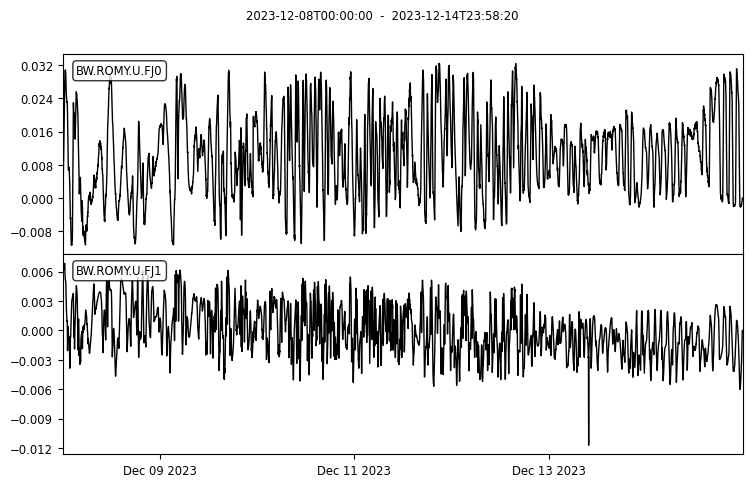

In [26]:
st.plot(equal_scale=False);

0.004840066545971956


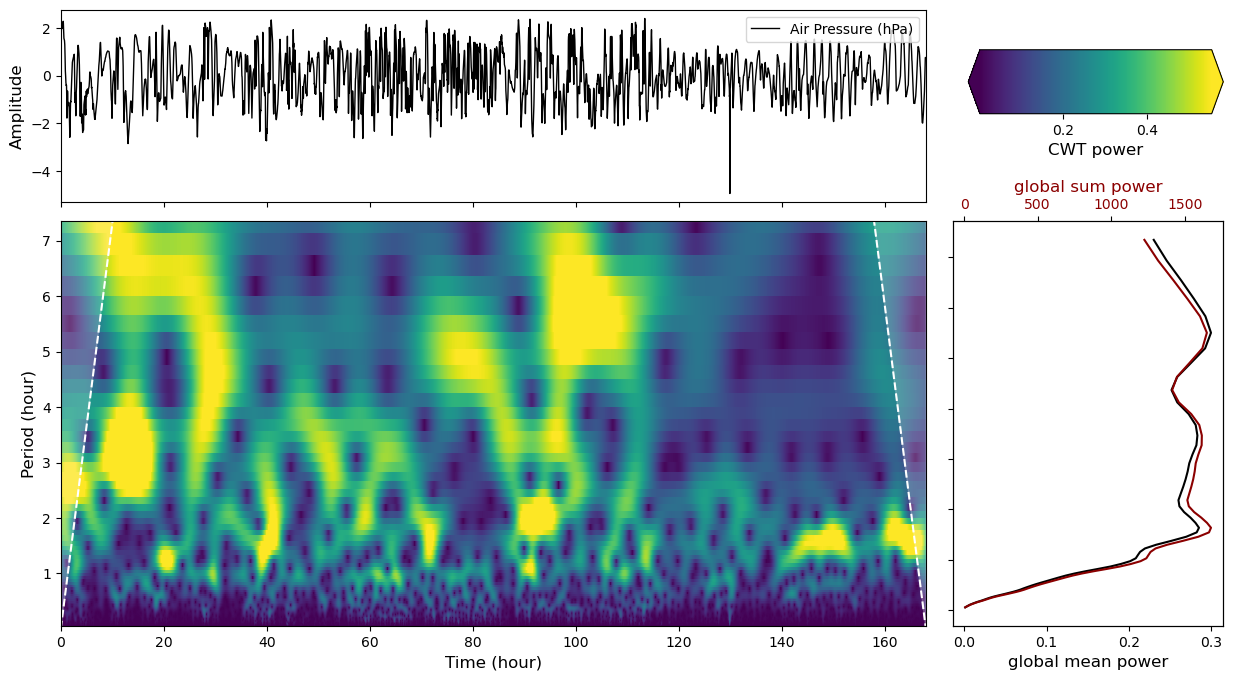

In [27]:
ttt = st[1].times()
arr = st[1].data
dt  = st[1].stats.delta # seconds

out = __compute_cwt(ttt, arr, dt, tscale="hour", datalabel="Air Pressure (hPa)",
                    log=False, period=True, fmax=None, plot=True)

out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT_2.png", format="png", dpi=200, bbox_inches='tight')


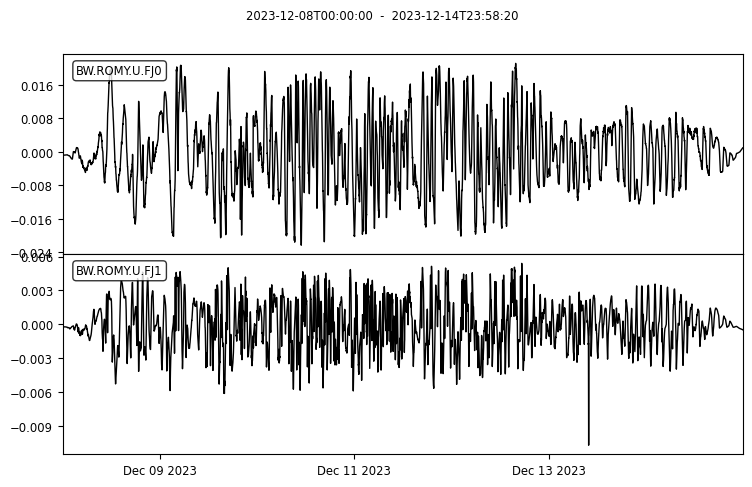

In [28]:
lp = st.copy()

lp = lp.detrend("simple")
lp = lp.taper(0.1)
# lp = lp.filter("bandpass", freqmin=1/(12*3600), freqmax=1/(1*3600), corners=4, zerophase=True)
lp = lp.filter("highpass", freq=1/(48*3600), corners=4, zerophase=True)
# lp = lp.filter("lowpass", freq=0.01, corners=4, zerophase=True)

lp.plot(equal_scale=False);

/tmp/ipykernel_203978/50255097.py:20: RuntimeWarning: divide by zero encountered in divide
  ax[0].semilogx(1/out['fcoh'], out['coh'])
/tmp/ipykernel_203978/50255097.py:23: RuntimeWarning: divide by zero encountered in divide
  ax[1].semilogx(1/out['ff1'], out['psd1'])
/tmp/ipykernel_203978/50255097.py:24: RuntimeWarning: divide by zero encountered in divide
  ax[2].semilogx(1/out['ff2'], out['psd2'])
/tmp/ipykernel_203978/50255097.py:27: RuntimeWarning: divide by zero encountered in divide
  ax11.semilogx(1/f1, psd1, color="tab:orange")
/tmp/ipykernel_203978/50255097.py:30: RuntimeWarning: divide by zero encountered in divide
  ax22.semilogx(1/f2, psd2, color="tab:orange")


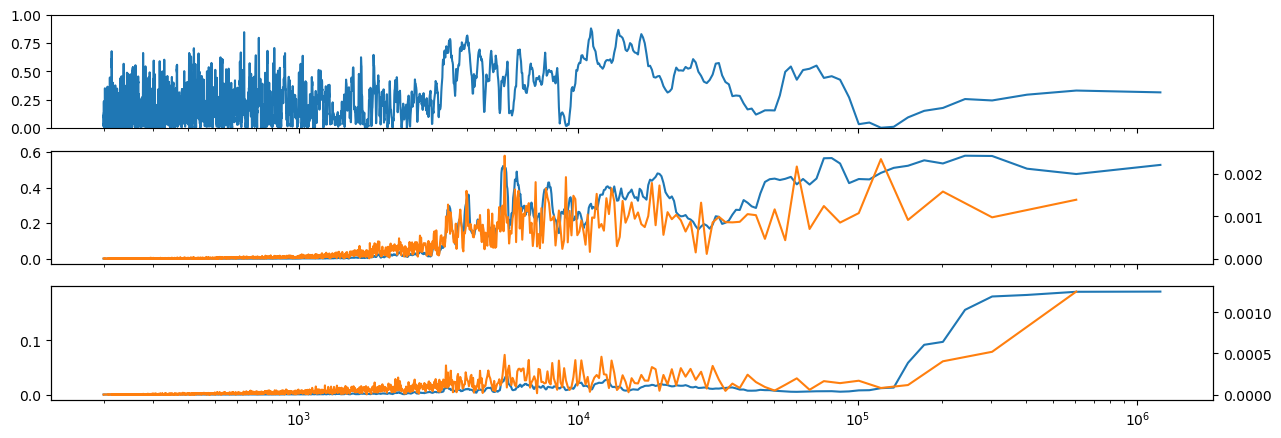

In [29]:
# dat1 = lp[0].data
# dat2 = lp[1].data
# dt, df = lp[0].stats.delta, lp[0].stats.delta

dat1 = st[0].data
dat2 = st[1].data
dt, df = st[0].stats.delta, st[0].stats.delta


out = __multitaper_coherence(dat1, dat2, dt, n_taper=10, time_bandwidth=3.5, method=2)


f1, psd1, pha1 = __get_fft(dat1, dt)
f2, psd2, pha2 = __get_fft(dat2, dt)



fig, ax = plt.subplots(3, 1, figsize=(15, 5), sharex=True)

ax[0].semilogx(1/out['fcoh'], out['coh'])
ax[0].set_ylim(0, 1)

ax[1].semilogx(1/out['ff1'], out['psd1'])
ax[2].semilogx(1/out['ff2'], out['psd2'])

ax11 = ax[1].twinx()
ax11.semilogx(1/f1, psd1, color="tab:orange")

ax22 = ax[2].twinx()
ax22.semilogx(1/f2, psd2, color="tab:orange")

plt.show();

In [30]:
# from scipy.signal import hilbert

# env0 = abs(hilbert(lp[0].data))
# env1 = abs(hilbert(lp[1].data))

# # plt.plot(env0)
# # plt.plot(env1*0.05)

# plt.plot(__smooth(env0, 200))
# plt.plot(__smooth(env1*0.01, 200))

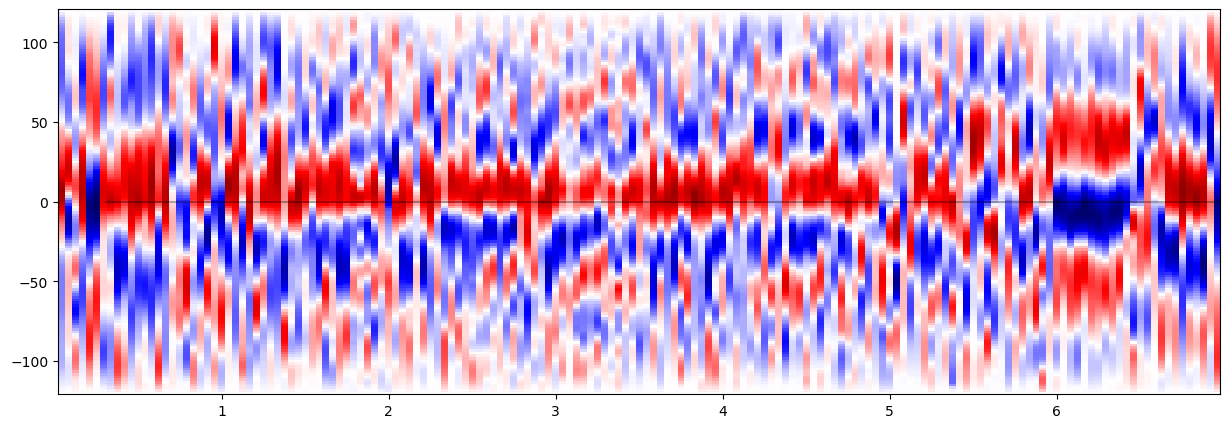

In [31]:
# dt = st[0].stats.delta
# dat1 = st[0].data
# dat2 = st[1].data

dt = lp[0].stats.delta
dat1 = lp[0].data
dat2 = lp[1].data

twin = 2*3600

ttt, ccf, tlags, shifts, maxima = __cross_correlation_function_windows(dat1, dat2, dt, twin, overlap=0.5, demean=True)


plt.figure(figsize=(15, 5))

cmap = plt.get_cmap("seismic")

plt.pcolormesh(ttt/86400, tlags/60, ccf.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
plt.axhline(0, min(ttt)/86400, max(ttt)/86400, color="k", alpha=0.3)

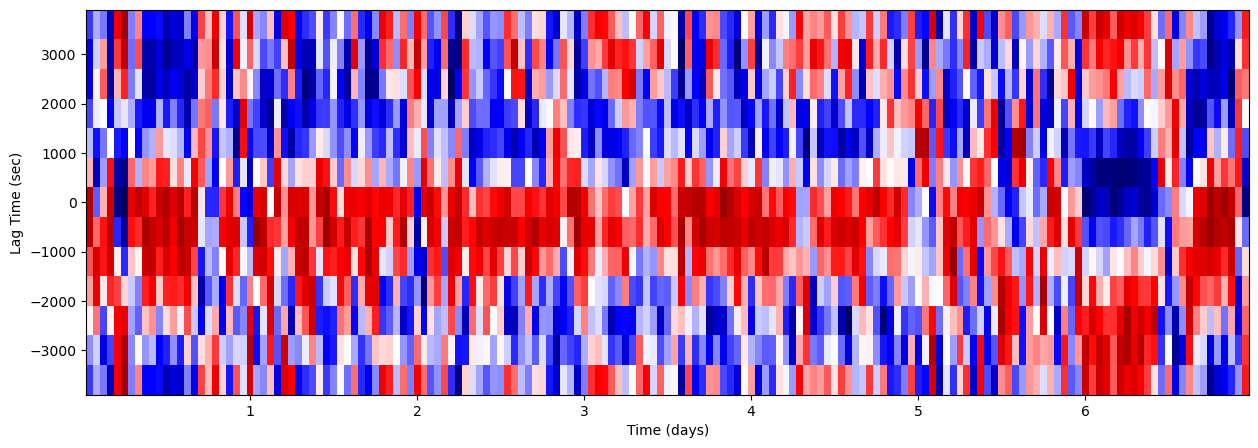

In [32]:
# dt = st[0].stats.delta
# dat1 = st[0].data
# dat2 = st[1].data

dt = lp[0].stats.delta
dat1 = lp[0].data
dat2 = lp[1].data

twin = 2*3600


tt, Tlags, ccc = __cc_lag_matrix(dat1, dat2, dt, twin, 1*3600, 600, plot=True)


/tmp/ipykernel_203978/851163732.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


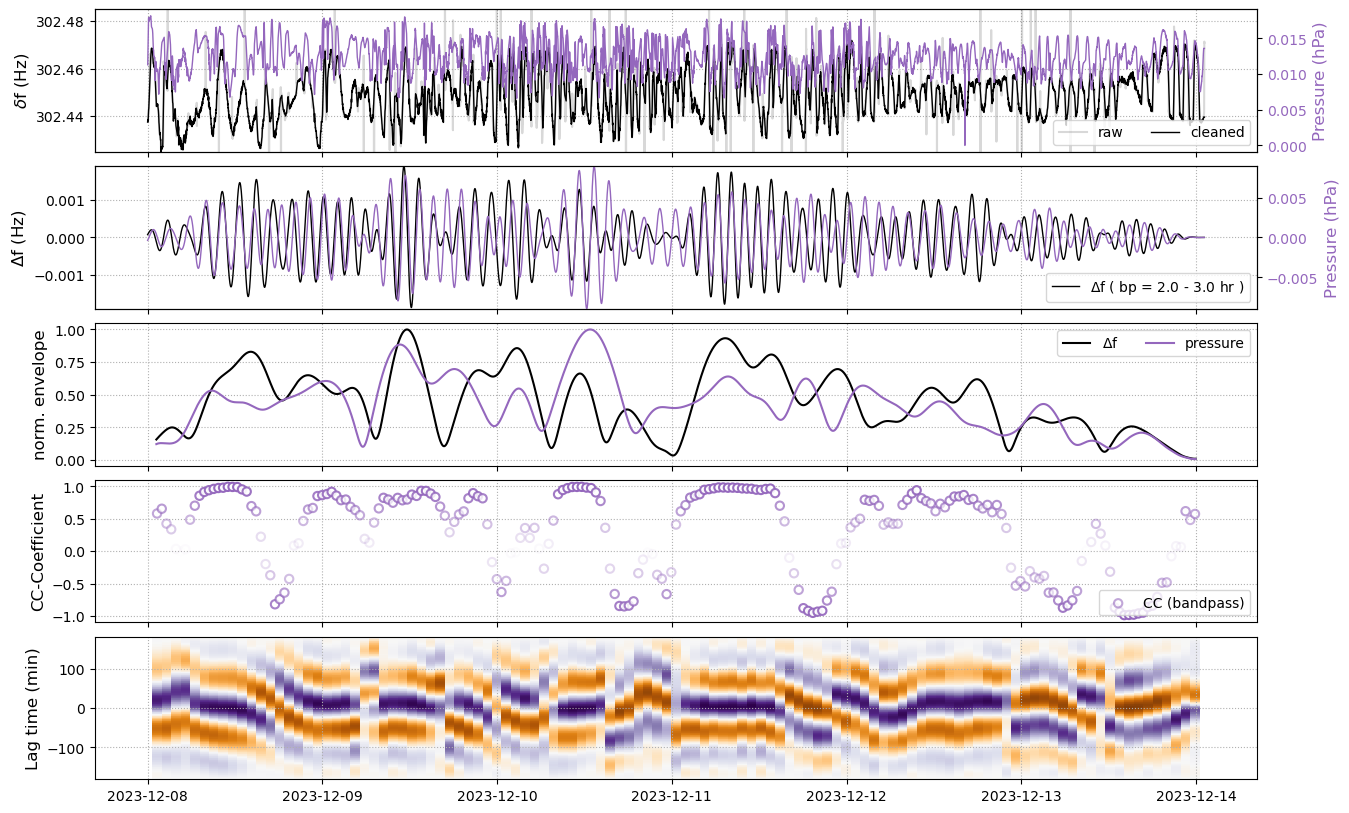

In [33]:
def __makeplot():

    from numpy import nanmax

    fl, fu = 1/(3*3600), 1/(2*3600)


    lp = st.copy()

    lp = lp.detrend("simple")
    lp = lp.taper(0.1)
    lp = lp.filter("bandpass", freqmin=fl, freqmax=fu, corners=4, zerophase=True)

    env0 = abs(hilbert(lp[0].data))
    env1 = abs(hilbert(lp[1].data))

    env0_smooth = __smooth(env0, 100)
    env1_smooth = __smooth(env1, 100)

    dt = st[0].stats.delta
    over = 0.75
    twin = 1/fl ## seconds

    tt, cc = __cross_correlation_windows(st[0].data, st[1].data, dt, twin, overlap=over, demean=True)
    tt_lp, cc_lp = __cross_correlation_windows(lp[0].data, lp[1].data, dt, twin, overlap=over, demean=False)


    Nrow, Ncol = 5, 1

    font = 12

    ref_date = str(bs.time1.iloc[0])[:10]

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(bs.time_sec, bs.w_s, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec, bs.w_s_inter, color="black", label="cleaned", lw=1)
    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f (Hz)", fontsize=font)


    ax00 = ax[0].twinx()
    ax00.plot(bs.time_sec, bs.f1_ac_inter, lw=1,
              color="tab:purple", label="AC1")
    ax00.set_ylabel("Pressure (hPa)", fontsize=font, color="tab:purple")
    [t.set_color('tab:purple') for t in ax00.yaxis.get_ticklabels()]


    ax[1].plot(lp[1].times(reftime=UTCDateTime(ref_date)),
               lp[1].data, color="k", label=f"$\Delta$f ( bp = {round(1/fu/3600, 1)} - {round(1/fl/3600,1)} hr )", lw=1)


    ax11 = ax[1].twinx()
    ax11.plot(lp[0].times(reftime=UTCDateTime(ref_date)),
              lp[0].data, color="tab:purple", label="WS5", lw=1)
    ax11.set_ylabel("Pressure (hPa)", fontsize=font, color="tab:purple")
    [t.set_color('tab:purple') for t in ax11.yaxis.get_ticklabels()]


    max_lim = max([abs(min(lp[1].data)), abs(max(lp[1].data))])
    ax[1].set_ylim(-max_lim, max_lim)

    max_lim = max([abs(min(lp[0].data)), abs(max(lp[0].data))])
    ax11.set_ylim(-max_lim, max_lim)

    ax[1].set_ylabel("$\Delta$f (Hz)", fontsize=font)



    ax[2].plot(lp[1].times(reftime=UTCDateTime(ref_date)),
               env1_smooth / nanmax(env1_smooth), color="black", label="$\Delta$f")
    ax[2].set_ylabel("norm. envelope", fontsize=font)


    ax[2].plot(lp[0].times(reftime=UTCDateTime(ref_date)),
              env0_smooth / nanmax(env0_smooth), color="tab:purple", label="pressure")
    # ax[2].set_ylabel("Pressure envelope", fontsize=font, color="tab:purple")
    # [t.set_color('tab:purple') for t in ax[2].yaxis.get_ticklabels()]


    # ax[3].plot(tt, cc, label="CC")
    # ax[3].plot(tt_lp, cc_lp, label="CC (bandpass)")
    ax[3].scatter(tt_lp, cc_lp, alpha=abs(cc_lp), label="CC (bandpass)", color="w", edgecolor="tab:purple", lw=1.5, zorder=2)
    ax[3].set_ylim(-1.1, 1.1)
    ax[3].set_ylabel("CC-Coefficient", fontsize=font)


    ttt, ccf, tlags, shifts, maxima = __cross_correlation_function_windows(lp[0].data, lp[1].data, dt, 1/fl, overlap=0.5, demean=True)
    cmap = plt.get_cmap("PuOr")
    ax[4].pcolormesh(ttt, tlags/60, ccf.T, rasterized=True, vmin=-1, vmax=1, cmap=cmap)
    ax[4].set_ylabel("Lag time (min)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        # ax[_n].set_xlim(left=0)

    ax[0].legend(loc=4, ncol=3)
    ax[1].legend(loc=4, ncol=3)
    ax[2].legend(loc=1, ncol=3)
    ax[3].legend(loc=4, ncol=3)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig


fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_temperature.png", format="png", dpi=150, bbox_inches='tight')
fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_pressure.png", format="png", dpi=150, bbox_inches='tight')


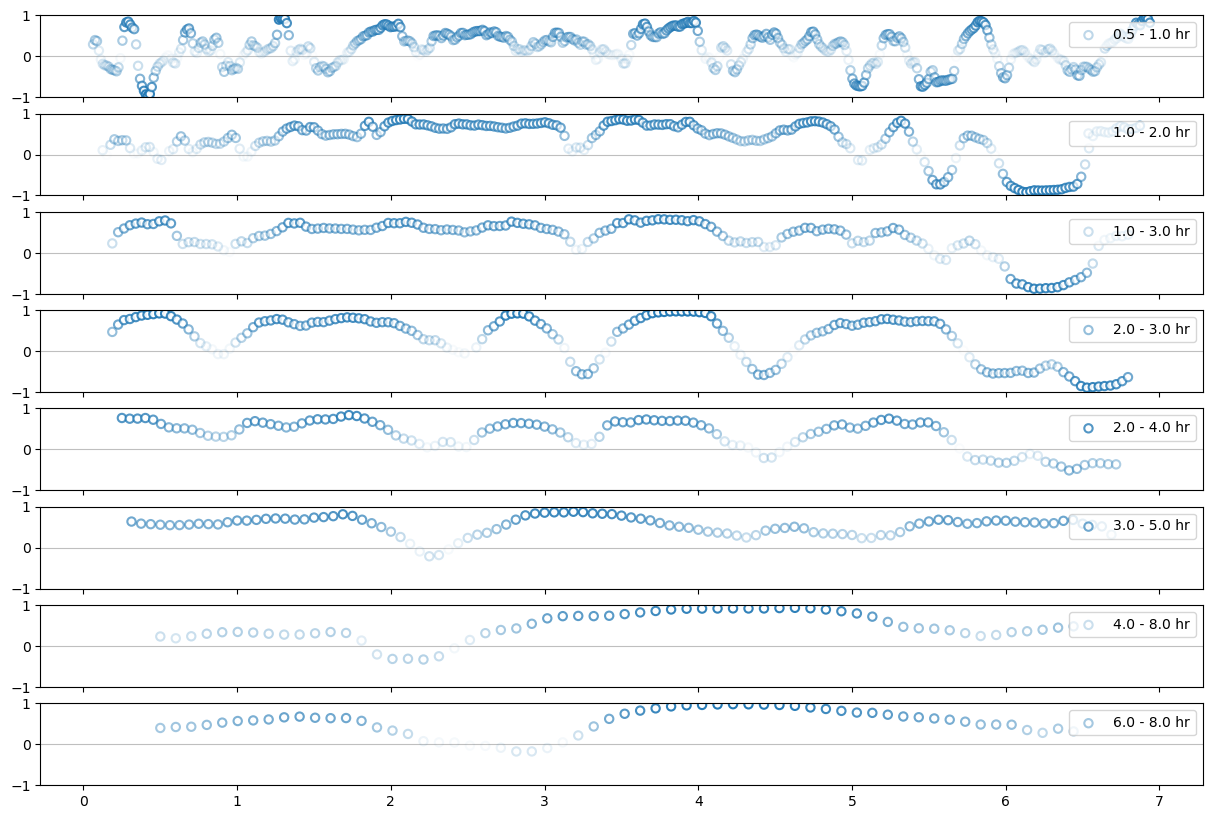

In [34]:
bands = [(0.5, 1.0),(1.0, 2.0), (1.0, 3.0), (2.0, 3.0), (2.0, 4.0), (3.0, 5.0), (4.0, 8.0), (6.0, 8.0)]

fig, ax = plt.subplots(len(bands), 1, figsize=(15, 10), sharex=True)


for _n, band in enumerate(bands):

    flower = 1/(band[1]*3600)
    fupper = 1/(band[0]*3600)

    lp = st.copy()

    lp = lp.detrend("simple")
    lp = lp.taper(0.1)
    lp = lp.filter("bandpass", freqmin=flower, freqmax=fupper, corners=4, zerophase=True)

    tt, cc = __cross_correlation_windows(lp[0].data, lp[1].data, lp[0].stats.delta, 3*band[1]*3600, overlap=0.9, lag=0, demean=False)

    # ax[_n].plot(tt/86400, cc, label=f"{band[0]} - {band[1]} hr", zorder=2)
    ax[_n].scatter(tt/86400, cc, alpha=abs(cc), label=f"{band[0]} - {band[1]} hr", color="w", edgecolor="tab:blue", lw=1.5, zorder=2)

    ax[_n].grid(axis="y", color="grey", zorder=0, alpha=0.5)

    ax[_n].legend(loc=1)

    ax[_n].set_ylim(-1, 1)

plt.show();

In [35]:
from functions.compute_wavelet_coherencey_transform import __compute_wavelet_coherency_transform

### Convert beat to tilt

$\delta$ f = S * $\Omega_E$ * sin($\phi_{lat}$ + $\theta_{dip}$ + $\epsilon_{tilt}$)

$\epsilon_{tilt}$ = arcsin( $\delta$ f / S / $\Omega_E$ ) - $\phi_{lat}$ - $\theta_{dip}$

In [36]:
from functions.sagnac_to_tilt import __sagnac_to_tilt

In [121]:
def __sagnac_to_geometry(data, ring):

    from numpy import sin, pi, deg2rad, sqrt, nanmedian

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## triangular height
    H = data * 3/2 * 632.8e-9 / (2*pi/86400 * sin(deg2rad(48.162941 + dip[ring])))

    ## side length
    a =  data * 3 / sqrt(3) * 632.8e-9 / (2*pi/86400 * sin(deg2rad(48.162941 + dip[ring])))

    H_expected = L[ring]/2*sqrt(3)

    # H_relative = abs(H-H_expected)
    # H_relative = H - nanmedian(H)

    out = {}
    out['triangular_height'] = H
    out['triangular_height_nominal'] = H_expected
    out['side_length'] = a

    return out

In [122]:
data = bs.w_s_inter

out = __sagnac_to_geometry(data, "U")

bs['w_s_a'] = out['side_length']
bs['w_s_H'] = out['triangular_height']

bs['w_s_tilt'] = __sagnac_to_tilt(data, "U")

/tmp/ipykernel_203978/212283348.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


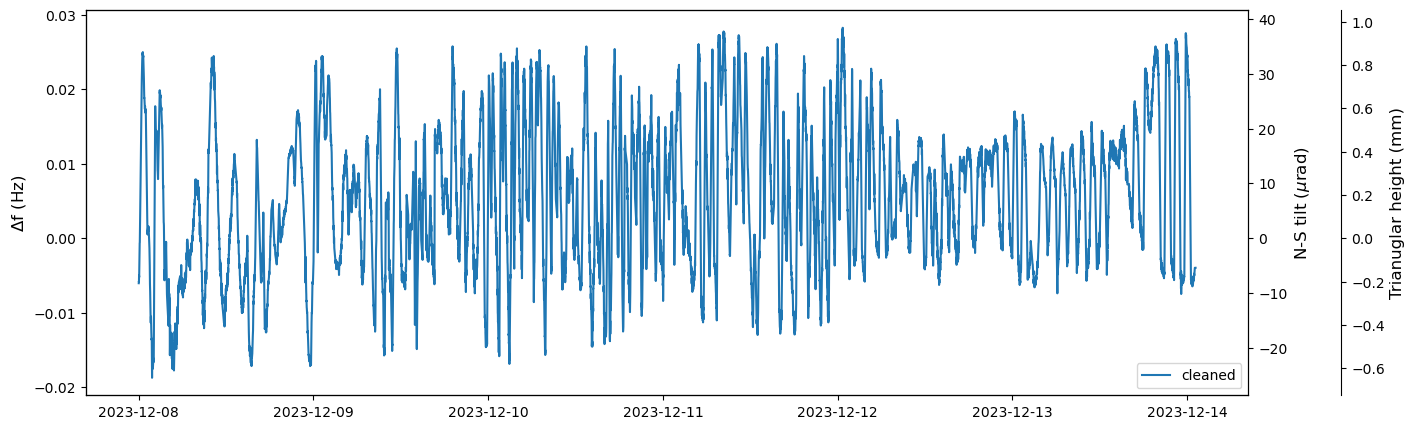

In [123]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    # ax.plot(bs.time_sec*time_scaling, __reduce(bs.w_s, 1440), color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, __reduce(bs.w_s_inter, 1440), color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.w_s_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    # ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\Delta$f (Hz)", fontsize=font)

    # ax.grid(ls=":", zorder=0)
    ax.legend(loc=4, ncol=3)
    # ax.set_xlim(left=0)


    ax11 = ax.twinx()
    ax11.plot(bs.time_sec*time_scaling, __reduce(bs.w_s_tilt, 1440)*1e6, color="tab:green", alpha=0., label="raw")
    ax11.set_ylabel("N-S tilt ($\mu$rad)", fontsize=font)
    ax11.ticklabel_format(useOffset=False)

    # ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax.get_yticks())))

    ax12 = ax.twinx()
    ax12.spines['right'].set_position(('axes', 1.08))
    ax12.plot(bs.time_sec*time_scaling, __reduce(bs.w_s_H, 1440)*1e3, color="tab:red", alpha=0., label="raw")
    ax12.set_ylabel("Trianuglar height (mm)", fontsize=font)

    # ax12.set_yticks(np.linspace(ax12.get_yticks()[0], ax12.get_yticks()[-1], len(ax.get_yticks())))


    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_scalefactor.png", format="png", dpi=150, bbox_inches='tight')


## Load Rain Data

In [ ]:
from andbro__load_FURT_stream import __load_furt_stream

In [ ]:
def __cumsum_rain(arr, n_samples):

    from numpy import cumsum, zeros, nansum, nanmean

    arr_out = zeros(len(arr))
    for i, dat in enumerate(arr):
        arr_out[i] = nansum(arr[i:i+n_samples])
        # arr_out[i] = nanmean(arr[i:i+n_samples])

    return arr_out

In [ ]:
furt = __load_furt_stream(config['tbeg'], config['tend'], path_to_archive=bay_path+'gif_online/FURT/WETTER/')

In [ ]:
rain = furt.select(channel="LAR")

In [ ]:
rain_cumsum = __cumsum_rain(rain[0].data, 3600)
rain_smooth = __smooth(__interpolate_nan(rain[0].data), 3600)


In [ ]:
# plt.plot(rain_cumsum/np.nanmax(rain_cumsum))
# plt.plot(rain_smooth/np.nanmax(rain_smooth))

In [ ]:
# ws1 = ws1.decimate(6, no_filter=False)
# ws1 = ws1.decimate(10, no_filter=False)

# ws5 = ws5.decimate(6, no_filter=False)
# ws5 = ws5.decimate(10, no_filter=False)

# ws9 = ws9.decimate(6, no_filter=False)
# ws9 = ws9.decimate(10, no_filter=False)

In [ ]:
from functions.smoothing import __smooth

ws1_T = ws1.select(channel="*T")[0].data
ws1_T_smooth = __smooth(ws1_T, 60)
ws1_gradient = np.gradient(ws1_T_smooth, 5)

ws5_T = ws5.select(channel="*T")[0].data
ws5_T_smooth = __smooth(ws5_T, 60)
ws5_gradient = np.gradient(ws5_T_smooth, 5)

ws9_T = ws9.select(channel="*T")[0].data
ws9_T_smooth = __smooth(ws9_T, 60)
ws9_gradient = np.gradient(ws9_T_smooth, 5)

In [ ]:
# # plt.plot(ws1_gradient)
# # plt.plot(ws5_gradient)
# plt.plot(ws1_gradient-ws5_gradient)

# plt.ylim(-0.01, 0.01)

## Plotting

### CWT

In [ ]:
def __compute_cwt(times, arr1, tdelta, datalabel="dat1", log=False, period=False, tscale='sec', fmax=None, normalize=True, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance, cwt
    from numpy import std, nanmean, nan, nansum, nanmax, nanmin, nanvar, ones, nan_to_num, polyfit, polyval, array, reshape, nanpercentile
    import matplotlib.pyplot as plt
    from numpy import sum as npsum

    times = array(times, dtype='float64')
    arr1 = array(arr1, dtype='float64')

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask


    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## detrend data
    p = polyfit(times - times[0], arr1, 1)
    dat_notrend = arr1 - polyval(p, times - times[0])
    std = dat_notrend.std()  # Standard deviation
    var = std ** 2  # Variance
    arr1 = dat_notrend / std  # Normalized dataset

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = 2 * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)


    cwt, scales, ff_cwt, cone_p, fft, fftfreqs = cwt(
                                                        arr1,
                                                        dt=dt,
                                                        dj=dj_set, #0.05,
                                                        s0=s0_set, #-1,
                                                        J=J_set, #-1,
                                                        wavelet=mother_wavelet,  # u'morlet',
                                                    )

    cone_f = 1/cone_p
    print(ff_cwt[0])
    pp_cwt = 1/ff_cwt

    if tscale == "min":
        times /= 60
        cone_p /= 60
        pp_cwt /= 60
        unit = "min"
    elif tscale == "hour":
        times /= 3600
        cone_p /= 3600
        pp_cwt /= 3600
        unit = "hour"
    else:
        unit = "s"

    ## building cone
    mask_cone = __mask_cone(cwt, ff_cwt, cone_f, fill=nan)


    ## get real part
    cwt_power = abs(cwt)

    ## normalize cross wavelet transform
    if normalize:
        cwt_power /= nanmax(cwt_power.reshape((1, cwt_power.size))[0])

    ## apply masks
    # cwt_power_masked = cwt_power * mask_cwt * mask_cone
    cwt_power_masked = cwt_power * mask_cone

    ## compute global cross wavelet transform power
    global_mean_cwt_f = nanmean(cwt_power_masked, axis=1)
    global_sum_cwt_f = nansum(cwt_power_masked, axis=1)

    # if normalize:
    #     global_sum_cwt_f /= max(global_sum_cwt_f)
    #     global_mean_cwt_f /= max(global_mean_cwt_f)


    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 4, 3

        font = 12

        fig = plt.figure(figsize=(15, 8))

        gs = GridSpec(Nrow, Ncol, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1:, :-1])
        ax3 = fig.add_subplot(gs[1:, 3:])

        ax1.set_xticklabels([])
        ax3.set_yticklabels([])

        plt.subplots_adjust(hspace=0.1, wspace=0.1)


        ax1.plot(times, arr1, alpha=1, color="black", lw=1, label=datalabel)

        ax1.set_xlim(min(times), max(times))
        ax1.set_ylabel("Amplitude", fontsize=font)
        ax1.legend(loc=1)



        if period:
            ca2 = ax2.pcolormesh(
                                times,
                                pp_cwt,
                                cwt_power,
                                # vmin=min(reshape(cwt_power, cwt_power.size)),
                                # vmax=max(reshape(cwt_power, cwt_power.size)),
                                vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 2),
                                vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 98),
                                )

            ax3.plot(global_mean_cwt_f, pp_cwt, color="black", label="global mean power")

            ax33 = ax3.twiny()
            ax33.plot(global_sum_cwt_f, pp_cwt, color="darkred", label="global sum power")

        else:
            ca2 = ax2.pcolormesh(
                                times,
                                ff_cwt,
                                cwt_power,
                                # vmin=min(reshape(cwt_power, cwt_power.size)),
                                # vmax=max(reshape(cwt_power, cwt_power.size)),
                                vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 2),
                                vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 98),
                                )


            ax3.plot(global_mean_cwt_f, ff_cwt, color="black", label="global mean power")

            ax33 = ax3.twiny()
            ax33.plot(global_sum_cwt_f, ff_cwt, color="darkred", label="global sum power")

        if period:
            ax2.plot(times, cone_p, color="white", ls="--")
            ax2.fill_between(times, cone_p, max(pp_cwt), color="white", alpha=0.2)
            ax2.set_ylabel(f"Period ({unit})", fontsize=font)
        else:
            ax2.plot(times, cone_f, color="white")
            ax2.fill_between(times, cone_f, min(ff_cwt), color="white", alpha=0.2)
            ax2.set_ylabel("Frequency (Hz)", fontsize=font)
            ax3.set_xlabel("Frequency (Hz)", fontsize=font)

        # ax3.legend()
        ax3.set_xlabel("global mean power", fontsize=font)
        ax33.set_xlabel("global sum power", fontsize=font, color="darkred")
        ax33.tick_params(axis='x', labelcolor="darkred")
        ax2.set_xlabel(f"Time ({unit})", fontsize=font)


        ## add colorbar
        cbar_ax = fig.add_axes([0.73, 0.75, 0.17, 0.08]) #[left, bottom, width, height]
        cb = plt.colorbar(ca2, cax=cbar_ax, orientation="horizontal", extend="both")
        cb.set_label("CWT power", fontsize=font, color="black")



        if fmax:
            if period:
                ax3.set_xlim(0, 1/(fmax*2))
            else:
                if fmax*2 <= 1/tdelta/2:
                    ax3.set_xlim(0, fmax*2)
                    ax2.set_ylim(0, fmax)
        else:
            if period:
                ax2.set_ylim(min(pp_cwt), max(pp_cwt))
            else:
                ax2.set_ylim(min(ff_cwt), max(ff_cwt))



        plt.show();

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_cwt
    out['cwt_power'] = cwt_power
    out['cone_mask'] = mask_cone
    out['global_mean_cwt'] = global_mean_cwt_f
    out['global_sum_cwt'] = global_sum_cwt_f


    if plot:
        out['fig'] = fig

    return out

## Tilt

In [ ]:
def __makeplot():

    dat = np.array(bs.w_s)

    tr = Trace()
    tr.data = dat
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    hr1 = 1
    tr1 = tr.copy()
    tr1 = tr1.detrend("demean")
    tr1 = tr1.taper(0.01)
    tr1 = tr1.filter("lowpass", freq=1/(hr1*3600), corners=2, zerophase=True)

    hr2 = 24
    tr2 = tr.copy()
    tr2.data = __sagnac_to_tilt(__interpolate_nan(dat), "U")
    tr2 = tr2.detrend("simple")
    tr2 = tr2.taper(0.01)
    tr2 = tr2.filter("lowpass", freq=1/(hr2*3600), corners=2, zerophase=True)

    scaling_factor = 0.01

    Nrow, Ncol = 2, 1

    font = 12

    tilt_scaling = 1e6
    time_scaling = 1

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_inter, color="grey", alpha=0.5, label=f"$\Delta$f w/ backscatter")
    ax[0].plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="black", label=f"$\Delta$f w/ backscatter (smoothed)")
    # ax[0].plot(bs.time_sec*time_scaling, tr1.data*1e3, color="black", label=f"$\Delta$f w/o backscatter (lp < {hr1} hour)")
    ax[0].set_ylim(302.41, 302.52)
    ax[0].ticklabel_format(useOffset=False)


    # ax[1].plot(bs.time_sec*time_scaling,
    #            tr2.data*tilt_scaling*scaling_factor,
    #            ls="--", color="k", label=f"{scaling_factor}* N-S tilt by $\Delta$f (lp < {hr2} hour)",
    #            zorder=2,
    #           )

    tromy_tilt = tromy.select(channel="*N")[0].data
    ax[1].plot(tromy.select(channel="*N")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:orange", label=f"N-S tilt",
               zorder=2,
              )

    tromy_tilt = tromy.select(channel="*E")[0].data
    ax[1].plot(tromy.select(channel="*E")[0].times(reftime=ref_time)*time_scaling,
               __reduce(__smooth(tromy_tilt, 600), 600)*tilt_scaling,
               color="tab:purple", label=f"E-W tilt",
               zorder=2,
              )

    ax11 = ax[1].twinx()
    ax11.fill_between(rain[0].times(reftime=ref_time)*time_scaling, rain_smooth, alpha=0.6, zorder=1)
    ax11.set_ylim(bottom=0)
    ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.tick_params(axis="y", colors="tab:blue")
    ax11.set_ylabel("Cumulative Rain (mm/hour)", fontsize=font, color="tab:blue")

    ax12 = ax[1].twinx()
    p12 = ax12.plot(tromy.select(channel="*T")[0].times(reftime=ref_time)*time_scaling,
                    tromy.select(channel="*T")[0].data, alpha=0.6, zorder=1, color="darkred", ls="--")

    # ax12.set_ylim(bottom=0)
    # ax12.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    # ax12.tick_params(axis="y", colors="tab:blue")
    ax12.set_ylabel("Temperature (°C)", fontsize=font, color="darkred")
    ax12.tick_params(axis='y', colors="darkred")
    ax12.spines.right.set_position(("axes", 1.10))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=1, fontsize=font-1)
    ax[1].legend(loc=1, fontsize=font-1, ncol=1)

    ax[0].set_ylabel(f"$\Delta$f (mHz)", fontsize=font)

    ax[1].set_ylabel("Tilt ($\mu$rad)", fontsize=font)
    ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    gc.collect();
    return fig


fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Rain_example.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
def __makeplot():


    f11 = 1/(14*3600)
    f12 = 1/(10*3600)

    f21 = 1/(26*3600)
    f22 = 1/(22*3600)

    detrend="demean"
    taper = 0.1
    corners = 4

    tr = Trace()
    tr.data = __sagnac_to_tilt(np.array(bs.fj_fs_inter), "U")
    tr.stats.delta = 60
    tr.stats.starttime = bs.time1[0]

    tr1 = tr.copy()
    tr1 = tr1.detrend(detrend).detrend("simple")
    tr1 = tr1.taper(taper)
    tr1 = tr1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)

    tr2 = tr.copy()
    tr2 = tr2.detrend(detrend).detrend("simple")
    tr2 = tr2.taper(taper)
    tr2 = tr2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)


    tromy1 = tromy.select(channel="*N").copy();
    tromy1 = tromy1.split()
    tromy1 = tromy1.detrend(detrend).detrend("simple")
    tromy1 = tromy1.taper(taper)
    tromy1 = tromy1.filter("bandpass", freqmin=f11, freqmax=f12, corners=corners, zerophase=True)
    tromy1 = tromy1.merge()


    tromy2 = tromy.select(channel="*N").copy();
    tromy2 = tromy2.split()
    tromy2 = tromy2.detrend(detrend).detrend("simple")
    tromy2 = tromy2.taper(taper)
    tromy2 = tromy2.filter("bandpass", freqmin=f21, freqmax=f22, corners=corners, zerophase=True)
    tromy2 = tromy2.merge()


    Nrow, Ncol = 2, 1

    font = 12

    scaling = 1e9

    ref_time = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(tromy1[0].times(reftime=ref_time), -tromy1[0].data*scaling, color="black", label="-1* N-S Tilt")
    ax[1].plot(tromy2[0].times(reftime=ref_time), -tromy2[0].data*scaling, color="black", label="-1* N-S Tilt")

    ax0 = ax[0].twinx()
    ax0.plot(tr1.times(reftime=ref_time), tr1.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax1 = ax[1].twinx()
    ax1.plot(tr2.times(reftime=ref_time), tr2.data*scaling, color="darkred", label="$\Delta $f  to Tilt")

    ax[0].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[1].set_ylabel("Tilt (nrad)", fontsize=font)
    # ax[1].set_xlabel(f"Time (days) from {config['tbeg'].date} {config['tbeg'].time} UTC", fontsize=font)

    ax0.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")
    ax1.set_ylabel("Tilt (nrad)", fontsize=font, color="darkred")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    ax0.legend(loc=4)
    ax1.legend(loc=4)

    ax[0].text(.01, .97, '(a) 11-13 h', ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.01, .97, '(b) 23-25 h', ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    ax[0].set_ylim(-40, 40)
    ax[1].set_ylim(-15, 15)

    ax0.tick_params(axis='y', colors='darkred')
    ax0.set_yticks(np.linspace(ax0.get_yticks()[0], ax0.get_yticks()[-1], len(ax[0].get_yticks())))

    ax1.tick_params(axis='y', colors='darkred')
    ax1.set_yticks(np.linspace(ax1.get_yticks()[0], ax1.get_yticks()[-1], len(ax[1].get_yticks())))

    ## add dates to x-axis
    ref_date = UTCDateTime(config['tbeg'])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SagnacFrequency_BS_RU_multiday_Case3_Tilt_Tides.png", format="png", dpi=150, bbox_inches='tight')
